In [1]:
import json
import shutil
import pickle
import numpy as np
import pandas as pd
from torch import load, sigmoid
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
import matplotlib.pyplot as plt
import scienceplots 
plt.style.use(['science','no-latex'])

import os
notebook_abs_path = os.path.abspath(os.getcwd())
REPO_ROOT = os.path.join(notebook_abs_path, os.pardir, os.pardir)

import sys
sys.path.append(REPO_ROOT)

vocab_size_str = "8k"
VOCABS = {vocab_size_str: 8192}
test_folder = os.path.join(REPO_ROOT, "data", "data_filtered", f"speakeasy_testset_BPE_{vocab_size_str}_lim_None")
train_folder = os.path.join(REPO_ROOT, "data", "data_filtered", f"speakeasy_trainset_BPE_{vocab_size_str}_lim_None")


## Loading models

In [4]:
infolder = "./out_mlm_vs_ar"

In [4]:
benchmark_no_pretraining_torch_path = os.path.join(infolder, r"ar_downstream_non_pretrained_1704971666\non_pretrained_final.torch")
benchmark_no_pretraining_model = load(benchmark_no_pretraining_torch_path)

benchmark_fulldata_torch_path = os.path.join(infolder, r"mlm_downstream_full_data_1704971666\full_data_final.torch")
benchmark_fulldata_model = load(benchmark_fulldata_torch_path)

autoregressive_torch_path = os.path.join(infolder, r"ar_downstream_pretrained_1704971666\pretrained_final.torch")
autoregressive_model = load(autoregressive_torch_path)

maskedlm_torch_path = os.path.join(infolder, r"mlm_downstream_pretrained_1704971666\pretrained_final.torch")
maskedlm_model = load(maskedlm_torch_path)

models = {
    "benchmark_full_data": benchmark_fulldata_model,
    "autoregressive_lm": autoregressive_model,
    "masked_lm": maskedlm_model,
    "benchmark_no_pretraining": benchmark_no_pretraining_model,
}

## Loading data

In [10]:
data_splits_npz = os.path.join(infolder, r"dataset_splits_1704971666.npz")
with open(data_splits_npz, 'rb') as f:
    splits = np.load(f)
    unlabeled_data = splits["unlabeled_data"]
    labeled_x = splits["labeled_x"]
    labeled_y = splits["labeled_y"]

# x_test = np.load(os.path.join(test_folder, f"speakeasy_vocab_size_{VOCABS[vocab_size_str]}_maxlen_512_x.npy"))
y_test = np.load(os.path.join(infolder, "speakeasy_y.npy"))

## Getting ROC curves over test data

In [11]:
logits_path = os.path.join(infolder, r"y_test_pred_logits.pkl")
if os.path.exists(logits_path):
    with open(logits_path, 'rb') as f:
        logits = pickle.load(f)
    print(f"Loaded logits from {logits_path}")
else:
    logits = {}
    from nebula.lit_utils import LitTrainerWrapper
    from nebula.models.attention import TransformerEncoderModel

    def collect_logits(
            model: TransformerEncoderModel,
            x_test: np.ndarray,
            y_test: np.ndarray,
            lim = None
    ):
        predictor = LitTrainerWrapper(
            pytorch_model=model,
            device="gpu",
            log_folder=None
        )
        predictor.setup_lit_model()
        
        test_dataloader = predictor.create_dataloader(x_test[0:lim], y_test[0:lim], batch_size=32, shuffle=False)
        y_pred_logits = predictor.predict_lit_model(test_dataloader, return_logits=True)

        temp_log_out = predictor.log_folder
        shutil.rmtree(temp_log_out)

        return y_pred_logits

    for model_name, model in models.items():
        logits[model_name] = collect_logits(model, x_test, y_test)

    # Save logits
    with open(logits_path, 'wb') as f:
        pickle.dump(logits, f)

Loaded logits from ./out_mlm_vs_ar/y_test_pred_logits.pkl


In [12]:
def plot_roc(
        y_test,
        y_pred_logits,
        model_name: str = "",
        ax=None,
        semilogx: bool = True,
        figsize=(8, 8)):
    y_pred = y_pred_logits > 0.5
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name:>20} -- f1: {f1:.4f}, acc: {acc:.4f}")

    y_pred_probs = sigmoid(y_pred_logits).cpu().detach().numpy()
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    if semilogx:
        ax.semilogx(fpr, tpr, label=f'{model_name} (f1 = {f1:.4f})')
    else:
        ax.plot(fpr, tpr, label=f'{model_name} (f1 = {f1:.4f})')
    
    return ax

 benchmark_full_data -- f1: 0.8950, acc: 0.8914
   autoregressive_lm -- f1: 0.8808, acc: 0.8804
           masked_lm -- f1: 0.8536, acc: 0.8583
benchmark_no_pretraining -- f1: 0.8479, acc: 0.8491


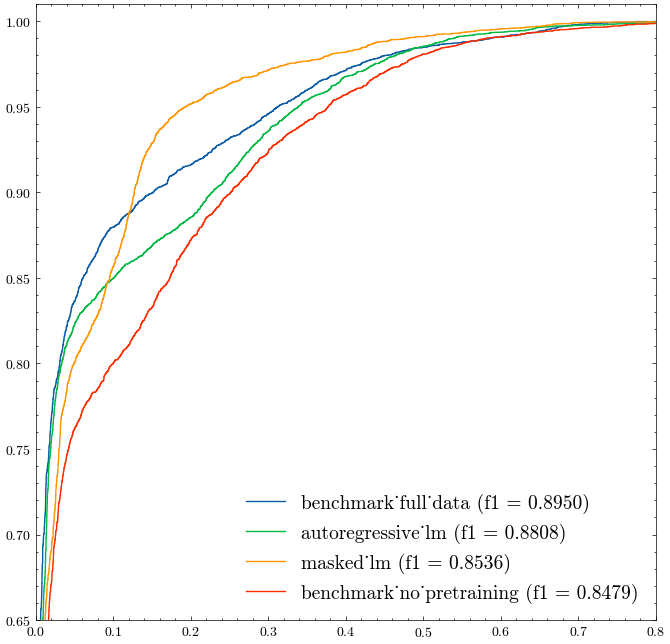

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

for model_name, logit in logits.items():
    # model_name = model_name.replace("benchmark_", "") if "benchmark_" in model_name else model_name
    plot_roc(y_test, logit, model_name, ax, semilogx=False)

ax.set_ylim(0.65, 1.01)
ax.set_xlim(0, 0.8)
_ = ax.legend(fontsize=14)

           full_data -- f1: 0.8950, acc: 0.8914
   autoregressive_lm -- f1: 0.8808, acc: 0.8804
           masked_lm -- f1: 0.8536, acc: 0.8583
      no_pretraining -- f1: 0.8479, acc: 0.8491


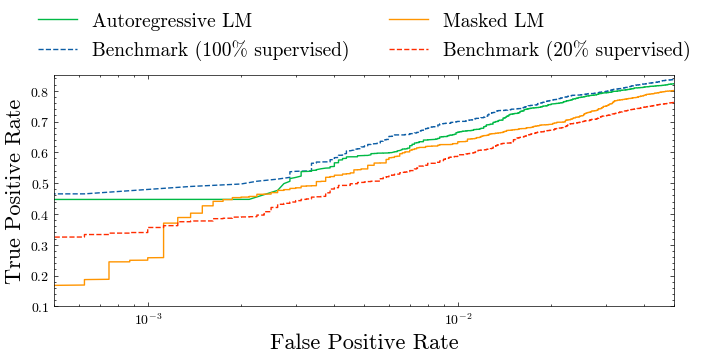

In [42]:
from nebula.misc.plots import set_size
fig, ax = plt.subplots(figsize=(8, 3))

for model_name, logit in logits.items():
    model_name = model_name.replace("benchmark_", "") if "benchmark_" in model_name else model_name
    plot_roc(y_test, logit, model_name, ax, semilogx=True)

ax.set_xlim(0.0005, 0.05)
ax.set_ylim(0.1, 0.85)
handles, labels = ax.get_legend_handles_labels()

f1_scores = [float(label.split("f1 = ")[1].split(")")[0]) for label in labels]

# as above, but w/o f1
new_labels = [
    "Benchmark (100% supervised)",
    "Autoregressive LM",
    "Masked LM",
    "Benchmark (20% supervised)",
]
handles[0].set_linestyle("--")
handles[3].set_linestyle("--")

# reorder handles and labels
handles = [handles[1], handles[0], handles[2], handles[3]]
new_labels = [new_labels[1], new_labels[0], new_labels[2], new_labels[3]]

ax.legend(
    handles,
    new_labels,
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.35),
    ncol=2
)

ax.set_ylabel("True Positive Rate", fontsize=16)
ax.set_xlabel("False Positive Rate", fontsize=16)

# ax.set_title("ROC Curves on Test Set with 20% of Training Set\nUsed for Supervised Finetuning", fontsize=14)

fig.savefig('img/training_modes_roc_semilogx.pdf', dpi=300, bbox_inches='tight')
